

**Model Weights (Google Drive)**

The trained BiLSTM and Transformer model weights can be obtained from here:  
https://drive.google.com/drive/folders/1O5oG586iDtR5kMNCZL3KoGppjCDyhXIM



# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 2](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

This task aims to categorize the sexist messages according to the intention of the author in one of the following categories: (i) direct sexist message, (ii) reported sexist message and (iii) judgemental message.

### Examples:

#### DIRECT
The intention was to write a message that is sexist by itself or incites to be sexist, as in:

''*A woman needs love, to fill the fridge, if a man can give this to her in return for her services (housework, cooking, etc), I don’t see what else she needs.*''

#### REPORTED
The intention is to report and share a sexist situation suffered by a woman or women in first or third person, as in:

''*Today, one of my year 1 class pupils could not believe he’d lost a race against a girl.*''

#### JUDGEMENTAL
The intention was to judge, since the tweet describes sexist situations or behaviours with the aim of condemning them.

''*As usual, the woman was the one quitting her job for the family’s welfare…*''

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2025-2026/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.


### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 2**.
- For Task 2, labels are assigned by six annotators.
- The labels for Task 2 represent whether the tweet is non-sexist ('-') or its sexist intention ('DIRECT', 'REPORTED', 'JUDGEMENTAL').







### Example

```
    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }
```

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as ``pandas.DataFrame``.
3. **Aggregate labels** for Task 2 using majority voting and store them in a new dataframe column called `label`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `label`.
6. **Encode the `label` column**: Use the following mapping

```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

In [ ]:
# Robust load of JSON as dict-of-records
import json

def load_split(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # Expect a dict keyed by id -> record
    if isinstance(data, dict):
        return pd.DataFrame(list(data.values()))
    # Otherwise fall back to DataFrame directly
    return pd.DataFrame(data)

# Overwrite previous DataFrames with normalized structure
df_train = load_split('/content/training.json')
df_val = load_split('/content/validation.json')
df_test = load_split('/content/test.json')

print('Loaded columns:', df_train.columns.tolist()[:12])
print('Sample row keys:', list(df_train.iloc[0].keys()))

Loaded columns: ['id_EXIST', 'lang', 'tweet', 'number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split']
Sample row keys: ['id_EXIST', 'lang', 'tweet', 'number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split']


In [ ]:
# Inspect loaded JSON structure
print('Train columns:', df_train.columns.tolist())
print('Train shape:', df_train.shape)
try:
    print('First row keys:', list(df_train.iloc[0].keys()))
    print('First row sample:', df_train.iloc[0])
except Exception as e:
    print('Row access failed:', e)

# If the JSON is a dict-of-records, transpose could help
if df_train.shape[0] == 1 and df_train.shape[1] > 10:
    df_train = df_train.T
    df_val = df_val.T
    df_test = df_test.T
    print('Transposed dataframes.')
    print('Train columns (after T):', df_train.columns.tolist())
    print('Train shape (after T):', df_train.shape)

Train columns: ['id_EXIST', 'lang', 'tweet', 'number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split']
Train shape: (6920, 11)
First row keys: ['id_EXIST', 'lang', 'tweet', 'number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split']
First row sample: id_EXIST                                                        100001
lang                                                                es
tweet                @TheChiflis Ignora al otro, es un capullo.El p...
number_annotators                                                    6
annotators           [Annotator_1, Annotator_2, Annotator_3, Annota...
gender_annotators                                   [F, F, F, M, M, M]
age_annotators                  [18-22, 23-45, 46+, 46+, 23-45, 18-22]
labels_task1                             [YES, YES, NO, YES, YES, YES]
labels_task2         [REPORTED, JUDGE

In [ ]:
# Majority voting aggregation for Task 2
from collections import Counter

label_map = {'-': 0, 'DIRECT': 1, 'JUDGEMENTAL': 2, 'REPORTED': 3}


def majority_vote_task2(labels):
    """Return the majority-voted label if a clear majority exists (>= 4 of 6)."""
    if labels is None or len(labels) == 0:
        return None
    counts = Counter(labels)
    top_label, top_count = counts.most_common(1)[0]
    # With 6 annotators, clear majority means at least 4 votes
    if top_count >= (len(labels) // 2 + 1):
        return top_label
    return None


def prepare_split(df):
    df = df.copy()
    # If JSON loaded as dict-of-records, transpose to get records as rows
    if 'labels_task2' not in df.columns and df.shape[0] == 1:
        df = df.T
    # Compute majority-voted label
    df['label'] = df['labels_task2'].apply(majority_vote_task2)
    # Drop samples without clear majority
    df = df.dropna(subset=['label'])
    # Keep only English tweets
    df = df[df['lang'] == 'en']
    # Select required columns
    df = df[['id_EXIST', 'lang', 'tweet', 'label']]
    # Encode label to integers
    df['label'] = df['label'].map(label_map).astype(int)
    return df

# Apply to each split
df_train_proc = prepare_split(df_train)
df_val_proc = prepare_split(df_val)
df_test_proc = prepare_split(df_test)

print('Train size:', len(df_train_proc))
print('Val size:', len(df_val_proc))
print('Test size:', len(df_test_proc))
print('Train label distribution:', df_train_proc['label'].value_counts().to_dict())

Train size: 2202
Val size: 115
Test size: 217
Train label distribution: {0: 1733, 1: 336, 3: 91, 2: 42}


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
# Task 2: Data Cleaning – remove emojis, hashtags, mentions, URLs, special chars, curly quotes; then lemmatize
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

# Ensure required NLTK resources are available
needed_corpora = ["wordnet", "omw-1.4"]
for pkg in needed_corpora:
    try:
        nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        nltk.download(pkg)
# Tokenizers and taggers
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")
# Newer NLTK requires punkt_tab
try:
    nltk.data.find("tokenizers/punkt_tab")
except LookupError:
    nltk.download("punkt_tab")
# Tagger standard and language-specific
try:
    nltk.data.find("taggers/averaged_perceptron_tagger")
except LookupError:
    nltk.download("averaged_perceptron_tagger")
try:
    nltk.data.find("taggers/averaged_perceptron_tagger_eng")
except LookupError:
    nltk.download("averaged_perceptron_tagger_eng")

# Emoji removal (Unicode ranges)
emoji_pattern = re.compile(
    r"[\U0001F600-\U0001F64F]"      # emoticons
    r"|[\U0001F300-\U0001F5FF]"     # symbols & pictographs
    r"|[\U0001F680-\U0001F6FF]"     # transport & map symbols
    r"|[\U0001F1E0-\U0001F1FF]"     # flags
    r"|[\U00002702-\U000027B0]"     # dingbats
    r"|[\U000024C2-\U0001F251]",    # enclosed characters
    flags=re.UNICODE
)

url_pattern = re.compile(r"http[s]?://\S+|www\.\S+", re.IGNORECASE)
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#\w+")
# Replace curly quotes with nothing (could also normalize to straight quotes)
fancy_quotes = {
    "\u2018": "", "\u2019": "",   # ‘ ’
    "\u201C": "", "\u201D": "",   # “ ”
}
# Remove special characters (keep letters, digits, spaces)
special_pattern = re.compile(r"[^a-zA-Z0-9\s]")

lemmatizer = WordNetLemmatizer()

# Map POS tags to WordNet
def _to_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN


def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Lowercase
    s = text.lower()
    # Remove URLs, mentions, hashtags
    s = url_pattern.sub(" ", s)
    s = mention_pattern.sub(" ", s)
    s = hashtag_pattern.sub(" ", s)
    # Remove emojis
    s = emoji_pattern.sub(" ", s)
    # Remove curly quotes
    for k, v in fancy_quotes.items():
        s = s.replace(k, v)
    # Remove special characters/punctuation
    s = special_pattern.sub(" ", s)
    # Collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s


def lemmatize_text(text: str) -> str:
    if not text:
        return ""
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens, lang="eng")
    lemmas = [lemmatizer.lemmatize(tok, _to_wordnet_pos(pos)) for tok, pos in tagged]
    return " ".join(lemmas)


def preprocess_tweet(text: str) -> str:
    return lemmatize_text(basic_clean(text))

# Apply cleaning to processed splits from Task 1
for name, df in [("train", df_train_proc), ("val", df_val_proc), ("test", df_test_proc)]:
    df[f"tweet_clean"] = df["tweet"].apply(preprocess_tweet)

# Quick sanity check
print("Sample cleaned (train):")
print(df_train_proc[["tweet", "tweet_clean"]].head(5))
print("Lengths before/after:")
print((df_train_proc["tweet"].str.len().fillna(0).mean(), df_train_proc["tweet_clean"].str.len().fillna(0).mean()))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Sample cleaned (train):
                                                  tweet  \
3661  Writing a uni essay in my local pub with a cof...   
3665  According to a customer I have plenty of time ...   
3667  New to the shelves this week - looking forward...   
3669  I guess that’s fairly normal for a Neanderthal...   
3670  #EverydaySexism means women usually end up in ...   

                                            tweet_clean  
3661  write a uni essay in my local pub with a coffe...  
3665  accord to a customer i have plenty of time to ...  
3667  new to the shelf this week look forward to rea...  
3669      i guess thats fairly normal for a neanderthal  
3670  mean woman usually end up in low paid support ...  
Lengths before/after:
(np.float64(173.2897366030881), np.float64(134.14078110808356))


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





In [ ]:
# Task 3: Build GloVe-based vocabulary and embedding matrix
import numpy as np

# Try importing gensim; if missing, hint to install
try:
    import gensim.downloader as api
except Exception as e:
    print("gensim not found. Please install with: !pip install gensim")
    raise

# Choose embedding dimension (e.g., 100)
embedding_dim = 100
print(f"Loading GloVe vectors: glove-wiki-gigaword-{embedding_dim} ...")

glove = api.load(f"glove-wiki-gigaword-{embedding_dim}")
print("Loaded GloVe.", "Vocab size:", len(glove.key_to_index))

# Tokenize cleaned tweets (simple whitespace split)
def tokenize(text: str):
    if not isinstance(text, str) or not text:
        return []
    return [t for t in text.split() if t]

# Build vocabulary from TRAIN set only (per instructions)
SPECIAL_TOKENS = {"<PAD>": 0, "<UNK>": 1}
idx2tok = ["<PAD>", "<UNK>"]
tok2idx = {"<PAD>": 0, "<UNK>": 1}

train_tokens = set()
for t in df_train_proc["tweet_clean"].tolist():
    train_tokens.update(tokenize(t))

# Deterministic ordering for reproducibility
for tok in sorted(train_tokens):
    if tok not in tok2idx:
        tok2idx[tok] = len(idx2tok)
        idx2tok.append(tok)

vocab_size = len(idx2tok)
print("Vocab size (train + specials):", vocab_size)

# Build embedding matrix
rng = np.random.default_rng(seed=42)
embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)

# PAD = zeros already
# Compute UNK as mean of all GloVe vectors to be a stable static embedding
# If glove set is big, compute mean over a sample to speed up
sample_keys = list(glove.key_to_index.keys())
sample = sample_keys[:50000] if len(sample_keys) > 50000 else sample_keys
unk_vec = np.mean([glove[k] for k in sample], axis=0).astype(np.float32)
embedding_matrix[SPECIAL_TOKENS["<UNK>"]] = unk_vec

covered = 0
for tok, idx in tok2idx.items():
    if tok in SPECIAL_TOKENS:
        continue
    if tok in glove.key_to_index:
        embedding_matrix[idx] = glove[tok]
        covered += 1
    else:
        # Random init for tokens not in GloVe (training-only OOV)
        embedding_matrix[idx] = rng.normal(loc=0.0, scale=0.05, size=(embedding_dim,)).astype(np.float32)

coverage = covered / (vocab_size - len(SPECIAL_TOKENS)) if vocab_size > len(SPECIAL_TOKENS) else 0.0
print(f"GloVe coverage over train tokens: {coverage:.3%}")

# Helper to convert tokenized text to ids with UNK fallback
def tokens_to_ids(tokens):
    return [tok2idx.get(tok, SPECIAL_TOKENS["<UNK>"]) for tok in tokens]

# Example conversions
ex = df_train_proc["tweet_clean"].iloc[0]
print("Example text:", ex)
print("IDs:", tokens_to_ids(tokenize(ex))[:20])


Loading GloVe vectors: glove-wiki-gigaword-100 ...
[==================================================] 100.0% 128.1/128.1MB downloaded
Loaded GloVe. Vocab size: 400000
Vocab size (train + specials): 7869
GloVe coverage over train tokens: 90.530%
Example text: write a uni essay in my local pub with a coffee random old man keep ask me drunk question when i m try to concentrate amp end with good luck but you ll just end up get married and not use it anyway be alive and well
IDs: [7770, 198, 7320, 2485, 3538, 4673, 4182, 5584, 7703, 198, 1477, 5686, 4952, 4313, 3911, 624, 4413, 2244, 5637, 7630]


In [ ]:
# OOV handling: build sequences and report OOV rates for val/test
import numpy as np

# Compute 95th percentile of train sequence lengths and clamp
train_lengths = [len(tokenize(t)) for t in df_train_proc["tweet_clean"].tolist()]
max_len = int(np.quantile(train_lengths, 0.95)) if len(train_lengths) else 50
max_len = max(10, min(max_len, 100))
print("Chosen max_len:", max_len)


def pad_truncate(ids, max_len):
    if len(ids) >= max_len:
        return ids[:max_len]
    return ids + [SPECIAL_TOKENS["<PAD>"]] * (max_len - len(ids))


def encode_split(df, max_len):
    X = [pad_truncate(tokens_to_ids(tokenize(t)), max_len) for t in df["tweet_clean"].tolist()]
    y = df["label"].to_numpy(dtype=np.int64)
    return np.asarray(X, dtype=np.int32), y


def oov_rate(df):
    total, oov = 0, 0
    for t in df["tweet_clean"]:
        toks = tokenize(t)
        total += len(toks)
        oov += sum(1 for tok in toks if tok not in tok2idx)
    return (oov / total) if total else 0.0

print(f"OOV rate (val): {oov_rate(df_val_proc):.2%}")
print(f"OOV rate (test): {oov_rate(df_test_proc):.2%}")

X_train, y_train = encode_split(df_train_proc, max_len)
X_val, y_val = encode_split(df_val_proc, max_len)
X_test, y_test = encode_split(df_test_proc, max_len)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Label classes (train):", sorted(set(y_train.tolist())))


Chosen max_len: 50
OOV rate (val): 8.78%
OOV rate (test): 8.39%
Shapes: (2202, 50) (115, 50) (217, 50)
Label classes (train): [0, 1, 2, 3]


### What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., ``<UNK>``) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* **Stacked**: add an additional Bidirectional LSTM layer to the Baseline model.

**Note**: You are **free** to experiment with hyper-parameters.

In [ ]:
# If TensorFlow is missing, install it in-notebook
import sys
import tensorflow as tf

num_classes = int(len(set(y_train.tolist())))
print("Classes:", num_classes)

embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False,
    name="encoder_embedding"
)

def build_baseline_bilstm(max_len: int,
                          lstm_units: int = 128,
                          dropout: float = 0.2) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="tokens")
    x = embedding_layer(inputs)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout),
        name="bilstm"
    )(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="classifier")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="baseline_bilstm")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")])
    return model


def build_stacked_bilstm(max_len: int,
                         lstm_units_1: int = 128,
                         lstm_units_2: int = 64,
                         dropout: float = 0.2) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="tokens")
    x = embedding_layer(inputs)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units_1, return_sequences=True, dropout=dropout, recurrent_dropout=dropout),
        name="bilstm_1"
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units_2, return_sequences=False, dropout=dropout, recurrent_dropout=dropout),
        name="bilstm_2"
    )(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="classifier")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="stacked_bilstm")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")])
    return model

baseline_model = build_baseline_bilstm(max_len=max_len)
stacked_model = build_stacked_bilstm(max_len=max_len)

baseline_model.summary()
stacked_model.summary()


Classes: 4


Model: "baseline_bilstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tokens (InputLayer)         [(None, 50)]              0         
                                                                 
 encoder_embedding (Embeddi  (None, 50, 100)           786900    
 ng)                                                             
                                                                 
 bilstm (Bidirectional)      (None, 256)               234496    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 classifier (Dense)          (None, 4)                 1028      
                                                                 
Total params: 1022424 (3.90 MB)
Trainable params: 235524 (920.02 KB)
Non-trainable params: 786900 (3.00 MB)
_________

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape ``(batch_size, # tokens, embedding_dim)`` to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Stacked models.



### Instructions

* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

In [ ]:
# Task 5: Training & Evaluation (macro F1, precision, recall across seeds)
import os, sys, subprocess, random, time
import numpy as np

# Ensure sklearn is available
try:
    from sklearn.metrics import precision_recall_fscore_support
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scikit-learn"])  # silent install
    from sklearn.metrics import precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Helper to build a fresh Embedding layer each time
def make_embedding_layer():
    return layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=False,
        name="embedding"
    )

# Builders (fresh model per seed)

def build_baseline_bilstm_for_training(max_len:int, lstm_units:int=64, dropout:float=0.2):
    inp = layers.Input(shape=(max_len,), dtype="int32", name="input_ids")
    emb = make_embedding_layer()(inp)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(emb)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inp, outputs=out, name="baseline_bilstm")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


def build_stacked_bilstm_for_training(max_len:int, lstm_units_1:int=64, lstm_units_2:int=32, dropout:float=0.2):
    inp = layers.Input(shape=(max_len,), dtype="int32", name="input_ids")
    emb = make_embedding_layer()(inp)
    x = layers.Bidirectional(layers.LSTM(lstm_units_1, return_sequences=True))(emb)
    x = layers.Bidirectional(layers.LSTM(lstm_units_2, return_sequences=False))(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inp, outputs=out, name="stacked_bilstm")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


# Training and evaluation across seeds

def train_and_eval(builder_fn, seeds, X_train, y_train, X_val, y_val, batch_size=64, epochs=15):
    results = []
    histories = {}
    best_seed = None
    best_macro_f1 = -1.0
    best_model = None

    for seed in seeds:
        os.environ["PYTHONHASHSEED"] = str(seed)
        tf.keras.utils.set_random_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        model = builder_fn(max_len)
        es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

        start = time.time()
        hist = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            callbacks=[es]
        )
        dur = time.time() - start
        histories[seed] = hist.history

        # Validation predictions
        y_prob = model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_prob, axis=1)

        # Macro metrics
        precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average="macro", zero_division=0)
        acc = (y_pred == y_val).mean()

        results.append({
            "seed": seed,
            "precision_macro": float(precision),
            "recall_macro": float(recall),
            "f1_macro": float(f1),
            "accuracy": float(acc),
            "epochs": len(hist.history.get("loss", [])),
            "train_time_sec": float(dur)
        })

        print(f"Seed {seed}: acc={acc:.4f} macroF1={f1:.4f} macroP={precision:.4f} macroR={recall:.4f} (epochs={results[-1]['epochs']}, {dur:.1f}s)")

        if f1 > best_macro_f1:
            best_macro_f1 = f1
            best_seed = seed
            best_model = model

    # Aggregate stats
    macro_f1s = [r["f1_macro"] for r in results]
    macro_ps = [r["precision_macro"] for r in results]
    macro_rs = [r["recall_macro"] for r in results]
    accs = [r["accuracy"] for r in results]

    summary = {
        "precision_macro_avg": float(np.mean(macro_ps)),
        "precision_macro_std": float(np.std(macro_ps)),
        "recall_macro_avg": float(np.mean(macro_rs)),
        "recall_macro_std": float(np.std(macro_rs)),
        "f1_macro_avg": float(np.mean(macro_f1s)),
        "f1_macro_std": float(np.std(macro_f1s)),
        "accuracy_avg": float(np.mean(accs)),
        "accuracy_std": float(np.std(accs)),
        "best_seed": int(best_seed),
        "best_f1_macro": float(best_macro_f1)
    }

    print("\nSummary:")
    print(f"macroF1: avg={summary['f1_macro_avg']:.4f} std={summary['f1_macro_std']:.4f}")
    print(f"macroP : avg={summary['precision_macro_avg']:.4f} std={summary['precision_macro_std']:.4f}")
    print(f"macroR : avg={summary['recall_macro_avg']:.4f} std={summary['recall_macro_std']:.4f}")
    print(f"accuracy: avg={summary['accuracy_avg']:.4f} std={summary['accuracy_std']:.4f}")
    print(f"Best seed: {summary['best_seed']} with macroF1={summary['best_f1_macro']:.4f}")

    return results, summary, best_model


# Execute for both architectures
seeds = [1, 42, 123]

print("\n=== Baseline BiLSTM ===")
base_results, base_summary, base_best_model = train_and_eval(build_baseline_bilstm_for_training, seeds, X_train, y_train, X_val, y_val)

print("\n=== Stacked BiLSTM ===")
stack_results, stack_summary, stack_best_model = train_and_eval(lambda ml: build_stacked_bilstm_for_training(ml, 64, 32, 0.2), seeds, X_train, y_train, X_val, y_val)

# Pick best overall by macro F1
best_overall_name = "baseline" if base_summary["f1_macro_avg"] >= stack_summary["f1_macro_avg"] else "stacked"
best_overall_summary = base_summary if best_overall_name == "baseline" else stack_summary
print(f"\nBest model family by average macroF1: {best_overall_name} -> macroF1(avg)={best_overall_summary['f1_macro_avg']:.4f}")



=== Baseline BiLSTM ===
Seed 1: acc=0.8435 macroF1=0.4558 macroP=0.5515 macroR=0.4196 (epochs=11, 9.8s)
Seed 42: acc=0.7913 macroF1=0.3925 macroP=0.4097 macroR=0.3879 (epochs=11, 6.9s)


Seed 123: acc=0.8087 macroF1=0.3923 macroP=0.4700 macroR=0.3784 (epochs=13, 8.4s)

Summary:
macroF1: avg=0.4135 std=0.0299
macroP : avg=0.4771 std=0.0581
macroR : avg=0.3953 std=0.0176
accuracy: avg=0.8145 std=0.0217
Best seed: 1 with macroF1=0.4558

=== Stacked BiLSTM ===
Seed 1: acc=0.8174 macroF1=0.4569 macroP=0.4653 macroR=0.4560 (epochs=15, 13.1s)
Seed 42: acc=0.8174 macroF1=0.4412 macroP=0.4691 macroR=0.4264 (epochs=12, 11.5s)
Seed 123: acc=0.8087 macroF1=0.4273 macroP=0.4721 macroR=0.4085 (epochs=10, 9.9s)

Summary:
macroF1: avg=0.4418 std=0.0121
macroP : avg=0.4689 std=0.0028
macroR : avg=0.4303 std=0.0196
accuracy: avg=0.8145 std=0.0041
Best seed: 1 with macroF1=0.4569

Best model family by average macroF1: stacked -> macroF1(avg)=0.4418


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
- **Load the Tokenizer and Model**

- **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

- **Train the Model**:
   Use the `Trainer` to train the model on your training data.

- **Evaluate the Model on the Test Set** using the same metrics used for LSTM-based models.

In [ ]:
# Task 6: Transformer-based Model (3 Random Seeds)
# Model: Twitter-RoBERTa-base for Hate Speech Detection


import numpy as np
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import precision_recall_fscore_support

# Load pretrained tokenizer
MODEL_NAME = "cardiffnlp/twitter-roberta-base-hate"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {MODEL_NAME}")

# Prepare HuggingFace datasets

print("\nPreparing HuggingFace datasets...")

hf_train = Dataset.from_pandas(df_train_proc[["tweet", "label"]])
hf_val   = Dataset.from_pandas(df_val_proc[["tweet", "label"]])
hf_test  = Dataset.from_pandas(df_test_proc[["tweet", "label"]])

def tokenize_batch(batch):
    """
    Tokenize a batch of tweets using the model tokenizer.
    Padding is handled dynamically by the data collator.
    """
    return tokenizer(
        batch["tweet"],
        truncation=True,
        max_length=128
    )

# Apply tokenization
hf_train = hf_train.map(tokenize_batch, batched=True)
hf_val   = hf_val.map(tokenize_batch, batched=True)
hf_test  = hf_test.map(tokenize_batch, batched=True)

# Remove raw text column
hf_train = hf_train.remove_columns(["tweet"])
hf_val   = hf_val.remove_columns(["tweet"])
hf_test  = hf_test.remove_columns(["tweet"])

# Set PyTorch tensor format for Trainer
hf_train.set_format("torch")
hf_val.set_format("torch")
hf_test.set_format("torch")

print("Datasets ready.")

# Metric computation

def compute_metrics_from_preds(logits, labels):
    """
    Compute macro-averaged Precision, Recall, F1-score
    and overall Accuracy.
    """
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0
    )

    accuracy = (preds == labels).mean()

    return {
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "accuracy": accuracy
    }

#Train and evaluate Transformer with 3 random seeds

seeds = [1, 42, 123]
transformer_results = []

print("\nStarting Transformer training with multiple seeds...")

for seed in seeds:
    print("\n-------------------------------")
    print(f" Transformer Training | Seed {seed}")
    print("-------------------------------")

    # Set random seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=4,
        ignore_mismatched_sizes=True
    )

    training_args = TrainingArguments(
        output_dir=f"./task6_seed_{seed}",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        seed=seed,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=hf_train,
        eval_dataset=hf_val,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Train the model
    trainer.train()

    # Evaluate on the TEST set
    test_output = trainer.predict(hf_test)

    metrics = compute_metrics_from_preds(
        test_output.predictions,
        test_output.label_ids
    )

    print("Test metrics:", metrics)
    transformer_results.append(metrics)


# Results table
df_transformer = pd.DataFrame(transformer_results)

df_transformer = df_transformer.rename(columns={
    "precision_macro": "Macro Precision",
    "recall_macro": "Macro Recall",
    "f1_macro": "Macro F1",
    "accuracy": "Accuracy"
})

df_transformer.insert(0, "Seed", seeds)

print("\nTransformer Results per Seed:")
df_transformer


# Aggregate results (Average ± Standard Deviation)

avg_std_row = {
    "Seed": "Avg ± Std",
    "Macro Precision": f"{df_transformer['Macro Precision'].mean():.4f} ± {df_transformer['Macro Precision'].std():.4f}",
    "Macro Recall": f"{df_transformer['Macro Recall'].mean():.4f} ± {df_transformer['Macro Recall'].std():.4f}",
    "Macro F1": f"{df_transformer['Macro F1'].mean():.4f} ± {df_transformer['Macro F1'].std():.4f}",
    "Accuracy": f"{df_transformer['Accuracy'].mean():.4f} ± {df_transformer['Accuracy'].std():.4f}",
}

df_transformer_final = pd.concat(
    [df_transformer, pd.DataFrame([avg_std_row])],
    ignore_index=True
)

print("\n===================================")
print(" Transformer Results (3 Seeds)")
print("===================================")
df_transformer_final

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Tokenizer loaded: cardiffnlp/twitter-roberta-base-hate

Preparing HuggingFace datasets...


Map:   0%|          | 0/2202 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Datasets ready.

Starting Transformer training with multiple seeds...

-------------------------------
 Transformer Training | Seed 1
-------------------------------


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

{'train_runtime': 122.7982, 'train_samples_per_second': 53.796, 'train_steps_per_second': 3.371, 'train_loss': 0.3646785717655495, 'epoch': 3.0}
Test metrics: {'precision_macro': 0.5287940379403795, 'recall_macro': 0.5323660714285714, 'f1_macro': 0.5301483143690406, 'accuracy': np.float64(0.8663594470046083)}

-------------------------------
 Transformer Training | Seed 42
-------------------------------
{'train_runtime': 129.6177, 'train_samples_per_second': 50.965, 'train_steps_per_second': 3.194, 'train_loss': 0.361407330646607, 'epoch': 3.0}
Test metrics: {'precision_macro': 0.5229720518064076, 'recall_macro': 0.5292410714285715, 'f1_macro': 0.5255684851072915, 'accuracy': np.float64(0.8571428571428571)}

-------------------------------
 Transformer Training | Seed 123
-------------------------------
{'train_runtime': 123.0295, 'train_samples_per_second': 53.694, 'train_steps_per_second': 3.365, 'train_loss': 0.3446371474703729, 'epoch': 3.0}
Test metrics: {'precision_macro': 0.513

,Seed,Macro Precision,Macro Recall,Macro F1,Accuracy
0,1,0.528794,0.532366,0.530148,0.866359
1,42,0.522972,0.529241,0.525568,0.857143
2,123,0.513272,0.529241,0.521022,0.857143
3,Avg ± Std,0.5217 ± 0.0078,0.5303 ± 0.0018,0.5256 ± 0.0046,0.8602 ± 0.0053


In [ ]:
#Classification Report  — Twitter-RoBERTa
from sklearn.metrics import classification_report
import numpy as np

# Predictions & labels
y_true = np.array(hf_test["label"])
y_pred = np.argmax(trainer.predict(hf_test).predictions, axis=1)

names = ['-', 'Direct', 'Judgemental', 'Reported']

# Classification report
print("\n--- Classification Report: Twitter-RoBERTa ---\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=names,
    digits=4,
    zero_division=0
))



--- Classification Report: Twitter-RoBERTa ---

              precision    recall  f1-score   support

           -     0.9198    0.9313    0.9255       160
      Direct     0.7333    0.7857    0.7586        42
 Judgemental     0.0000    0.0000    0.0000         5
    Reported     0.4000    0.4000    0.4000        10

    accuracy                         0.8571       217
   macro avg     0.5133    0.5292    0.5210       217
weighted avg     0.8385    0.8571    0.8476       217



#Extension: Multilingual Transformer Models (XLM-RoBERTa EN+ES) with Class Imbalance Mitigation

# Motivation:
Initial experiments with transformer-based models using Twitter-RoBERTa as an English baseline showed strong overall performance, but per-class analysis revealed weaker results on minority categories such as Judgemental and Reported sexism. This limitation is commonly observed in transformer models trained on imbalanced datasets, where majority classes dominate the learning process.

To address this, we extend the baseline by introducing multilingual training with XLM-RoBERTa, trained on English and Spanish data and evaluated on English test data. Multilingual representations are known to improve robustness and semantic generalization. However, multilingual training alone is not sufficient to fully mitigate class imbalance. Therefore, we further incorporate class-weighted loss to explicitly improve recall on under-represented classes.

In [ ]:
# Extension – Data Preparation (EN + ES)

def prepare_split_multilingual(df):
    df = df.copy()
    df["label"] = df["labels_task2"].apply(majority_vote_task2)
    df = df.dropna(subset=["label"])
    df = df[["id_EXIST", "lang", "tweet", "label"]]
    df["label"] = df["label"].map(label_map).astype(int)
    return df

# Load raw splits
df_train_raw = load_split("/content/training.json")
df_val_raw   = load_split("/content/validation.json")
df_test_raw  = load_split("/content/test.json")

# Apply majority voting
df_train_all = prepare_split_multilingual(df_train_raw)
df_val_all   = prepare_split_multilingual(df_val_raw)
df_test_all  = prepare_split_multilingual(df_test_raw)

# Train: EN + ES
df_train_en = df_train_all[df_train_all["lang"] == "en"]
df_train_es = df_train_all[df_train_all["lang"] == "es"]
df_train_mix = pd.concat([df_train_en, df_train_es], ignore_index=True)

# Validation / Test: EN only
df_val_en  = df_val_all[df_val_all["lang"] == "en"]
df_test_en = df_test_all[df_test_all["lang"] == "en"]

print("Train distribution:")
print(df_train_mix["lang"].value_counts())
print("EN val:", len(df_val_en))
print("EN test:", len(df_test_en))

Train distribution:
lang
es    2319
en    2202
Name: count, dtype: int64
EN val: 115
EN test: 217


In [ ]:
# Tokenization ( XLM-RoBERTa)

from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(
        batch["tweet"],
        truncation=True,
        max_length=128
    )

hf_train = Dataset.from_pandas(df_train_mix[["tweet", "label"]])
hf_val   = Dataset.from_pandas(df_val_en[["tweet", "label"]])
hf_test  = Dataset.from_pandas(df_test_en[["tweet", "label"]])

hf_train = hf_train.map(tokenize_batch, batched=True)
hf_val   = hf_val.map(tokenize_batch, batched=True)
hf_test  = hf_test.map(tokenize_batch, batched=True)

hf_train = hf_train.remove_columns(["tweet"]).with_format("torch")
hf_val   = hf_val.remove_columns(["tweet"]).with_format("torch")
hf_test  = hf_test.remove_columns(["tweet"]).with_format("torch")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/4521 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

# 1. Multilingual Transformer: XLM-RoBERTa (EN + ES)

To improve generalization beyond monolingual training, we adopt XLM-RoBERTa, a multilingual transformer pretrained on large-scale cross-lingual corpora. The model is trained on a combination of English and Spanish data and evaluated on English test samples, allowing us to assess the effect of multilingual exposure while keeping the evaluation language fixed.

In [ ]:
# XLM-R (EN + ES → EN test)
# Training with 3 Seeds

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0
    )

    accuracy = (preds == labels).mean()

    return {
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "accuracy": accuracy
    }

seeds = [1, 42, 123]
xlmr_results = []

for seed in seeds:
    print("\n===============================")
    print(f" XLM-R Training | Seed {seed}")
    print("===============================")

    torch.manual_seed(seed)
    np.random.seed(seed)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=4
    )

    training_args = TrainingArguments(
        output_dir=f"./xlmr_en_es_seed_{seed}",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        eval_strategy="epoch",
        save_strategy="no",
        seed=seed,
        report_to="none",
        logging_strategy="epoch",
        disable_tqdm=True
    )

    trainer_xlmr = Trainer(
        model=model,
        args=training_args,
        train_dataset=hf_train,   # EN + ES
        eval_dataset=hf_val,     # EN only
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    trainer_xlmr.train()

    test_metrics = trainer_xlmr.evaluate(hf_test)

    xlmr_results.append({
        "Seed": seed,
        "Macro Precision": test_metrics["eval_precision_macro"],
        "Macro Recall": test_metrics["eval_recall_macro"],
        "Macro F1": test_metrics["eval_f1_macro"],
        "Accuracy": test_metrics["eval_accuracy"]
    })

# Evaluation Results (3 Seeds)

df_xlmr = pd.DataFrame(xlmr_results)

avg_std = {
    "Seed": "Avg ± Std",
    "Macro Precision": f"{df_xlmr['Macro Precision'].mean():.4f} ± {df_xlmr['Macro Precision'].std():.4f}",
    "Macro Recall": f"{df_xlmr['Macro Recall'].mean():.4f} ± {df_xlmr['Macro Recall'].std():.4f}",
    "Macro F1": f"{df_xlmr['Macro F1'].mean():.4f} ± {df_xlmr['Macro F1'].std():.4f}",
    "Accuracy": f"{df_xlmr['Accuracy'].mean():.4f} ± {df_xlmr['Accuracy'].std():.4f}",
}

df_xlmr_final = pd.concat(
    [df_xlmr, pd.DataFrame([avg_std])],
    ignore_index=True
)

print("\n===================================")
print(" XLM-R Results (3 Seeds)")
print("===================================")

df_xlmr_final


 XLM-R Training | Seed 1


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

{'loss': 0.6736, 'grad_norm': 10.74560832977295, 'learning_rate': 1.3356890459363958e-05, 'epoch': 1.0}
{'eval_loss': 0.46018335223197937, 'eval_precision_macro': 0.38706140350877194, 'eval_recall_macro': 0.4587301587301587, 'eval_f1_macro': 0.41837732160312807, 'eval_accuracy': 0.8695652173913043, 'eval_runtime': 0.6358, 'eval_samples_per_second': 180.863, 'eval_steps_per_second': 12.582, 'epoch': 1.0}
{'loss': 0.4753, 'grad_norm': 22.318559646606445, 'learning_rate': 6.690223792697291e-06, 'epoch': 2.0}
{'eval_loss': 0.43942201137542725, 'eval_precision_macro': 0.6463647959183674, 'eval_recall_macro': 0.5033730158730159, 'eval_f1_macro': 0.5173758865248227, 'eval_accuracy': 0.8695652173913043, 'eval_runtime': 0.6379, 'eval_samples_per_second': 180.266, 'eval_steps_per_second': 12.54, 'epoch': 2.0}
{'loss': 0.3646, 'grad_norm': 7.859258651733398, 'learning_rate': 2.3557126030624265e-08, 'epoch': 3.0}
{'eval_loss': 0.49228018522262573, 'eval_precision_macro': 0.6532747119466343, 'eval_

,Seed,Macro Precision,Macro Recall,Macro F1,Accuracy
0,1,0.43422,0.438914,0.425506,0.81106
1,42,0.476054,0.465774,0.466329,0.834101
2,123,0.373299,0.409821,0.390445,0.820276
3,Avg ± Std,0.4279 ± 0.0517,0.4382 ± 0.0280,0.4274 ± 0.0380,0.8218 ± 0.0116


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predictions & labels
preds = trainer_xlmr.predict(hf_test)

y_true = np.array(hf_test["label"])
y_pred = np.argmax(preds.predictions, axis=1)

names = ['-', 'Direct', 'Judgemental', 'Reported']

# Classification report
print("\n--- Classification Report: XLM-RoBERTa (EN + ES) ---\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=names,
    digits=4,
    zero_division=0
))



--- Classification Report: XLM-RoBERTa (EN + ES) ---

              precision    recall  f1-score   support

           -     0.8810    0.9250    0.9024       160
      Direct     0.6122    0.7143    0.6593        42
 Judgemental     0.0000    0.0000    0.0000         5
    Reported     0.0000    0.0000    0.0000        10

    accuracy                         0.8203       217
   macro avg     0.3733    0.4098    0.3904       217
weighted avg     0.7680    0.8203    0.7930       217



# 2. Class-Weighted Loss

The dataset exhibits a strong class imbalance, with minority categories such as Judgemental and Reported sexism being significantly under-represented. To mitigate this issue, we incorporate a class-weighted loss during training, assigning higher penalties to misclassification of minority classes. This encourages the model to reduce false negatives and improves recall on rare but socially relevant categories.

However, this approach introduces a trade-off: increasing sensitivity to minority classes may lead to a slight reduction in precision for majority classes, as the model becomes more conservative in its predictions. Despite this, class-weighted loss provides a favorable balance between overall performance and fairness across classes, particularly in applications where missing minority instances is more critical than occasional false positives.

In [ ]:
# Class Weights (EN + ES train)

from sklearn.utils.class_weight import compute_class_weight


train_labels = df_train_mix["label"].values

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights:")
for i, w in enumerate(class_weights):
    print(f"Class {i}: {w:.3f}")


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fn = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


Class weights:
Class 0: 0.336
Class 1: 1.342
Class 2: 10.369
Class 3: 5.568


In [ ]:
# XLM-R (EN + ES, Class-Weighted → EN test)

from transformers import AutoModelForSequenceClassification, TrainingArguments
from transformers import DataCollatorWithPadding

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4
)

# Training configuration
training_args = TrainingArguments(
    output_dir="./xlmr_en_es_weighted",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="no",
    seed=seed,
    report_to="none",
    logging_strategy="epoch",
    disable_tqdm=True
)

# Trainer (WEIGHTED)
trainer_weighted = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,   # EN + ES
    eval_dataset=hf_val,     # EN only
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)


# Train
trainer_weighted.train()

# Test evaluation
weighted_test_metrics = trainer_weighted.evaluate(hf_test)

weighted_results_table = pd.DataFrame([
    {
        "Model": "XLM-R (EN + ES, Class-Weighted)",
        "Macro Precision": weighted_test_metrics["eval_precision_macro"],
        "Macro Recall": weighted_test_metrics["eval_recall_macro"],
        "Macro F1": weighted_test_metrics["eval_f1_macro"],
        "Accuracy": weighted_test_metrics["eval_accuracy"]
    }
])

print("\n===================================")
print(" Class-Weighted XLM-R Test Results")
print("===================================")

weighted_results_table


{'loss': 1.2434, 'grad_norm': 34.56614685058594, 'learning_rate': 1.3356890459363958e-05, 'epoch': 1.0}
{'eval_loss': 1.1405706405639648, 'eval_precision_macro': 0.539425105485232, 'eval_recall_macro': 0.7083333333333333, 'eval_f1_macro': 0.5802268244575937, 'eval_accuracy': 0.782608695652174, 'eval_runtime': 0.6482, 'eval_samples_per_second': 177.403, 'eval_steps_per_second': 12.341, 'epoch': 1.0}
{'loss': 0.8677, 'grad_norm': 30.539140701293945, 'learning_rate': 6.690223792697291e-06, 'epoch': 2.0}
{'eval_loss': 1.0401480197906494, 'eval_precision_macro': 0.6708333333333333, 'eval_recall_macro': 0.7668650793650794, 'eval_f1_macro': 0.7067021000777806, 'eval_accuracy': 0.8521739130434782, 'eval_runtime': 0.7874, 'eval_samples_per_second': 146.044, 'eval_steps_per_second': 10.16, 'epoch': 2.0}
{'loss': 0.6544, 'grad_norm': 78.17305755615234, 'learning_rate': 2.3557126030624265e-08, 'epoch': 3.0}
{'eval_loss': 1.206345796585083, 'eval_precision_macro': 0.6943580542264752, 'eval_recall_m

,Model,Macro Precision,Macro Recall,Macro F1,Accuracy
0,"XLM-R (EN + ES, Class-Weighted)",0.516987,0.608333,0.548822,0.78341


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predictions
preds = trainer_weighted.predict(hf_test)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

labels = ['-', 'Direct', 'Judgemental', 'Reported']

print("\n--- Classification Report: XLM-R (EN + ES, Class-Weighted) ---\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=labels,
        digits=3,
        zero_division=0
    )
)



--- Classification Report: XLM-R (EN + ES, Class-Weighted) ---

              precision    recall  f1-score   support

           -      0.934     0.800     0.862       160
      Direct      0.614     0.833     0.707        42
 Judgemental      0.167     0.200     0.182         5
    Reported      0.353     0.600     0.444        10

    accuracy                          0.783       217
   macro avg      0.517     0.608     0.549       217
weighted avg      0.828     0.783     0.797       217



# Model Performance Comparison

This section compares the performance of all evaluated models on the English test set, including BiLSTM-based architectures, a monolingual Transformer model (Twitter-RoBERTa), and multilingual Transformer variants based on XLM-RoBERTa. Overall, Transformer-based models consistently outperform the BiLSTM architecture in terms of Macro F1-score, confirming the importance of contextualized representations for sexism detection. Among Transformers, Twitter-RoBERTa achieves the highest overall accuracy, reflecting its strong suitability for social media text and its ability to model the dominant class distribution in a highly imbalanced dataset.

Although XLM-RoBERTa trained on multilingual data (English + Spanish) yields competitive results, it does not surpass the monolingual Twitter-RoBERTa baseline, likely due to class imbalance: multilingual training alone introduces additional variability but does not explicitly address the under-representation of minority classes. This limitation is mitigated when applying a class-weighted loss to XLM-RoBERTa, which substantially improves Macro F1-score by increasing recall for minority classes, albeit at the cost of reduced overall accuracy.

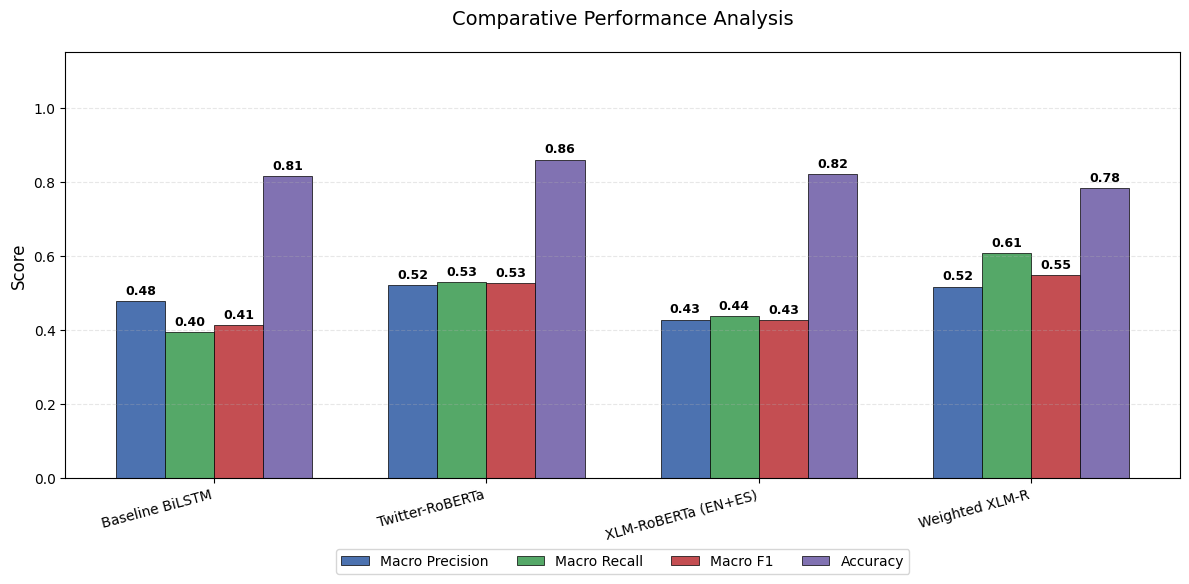


--- Final Comparison Table ---
              Model  Macro Precision  Macro Recall  Macro F1  Accuracy
    Baseline BiLSTM         0.477106      0.395304  0.413528  0.814493
    Twitter-RoBERTa         0.521679      0.530283  0.525579  0.860215
XLM-RoBERTa (EN+ES)         0.427858      0.438170  0.427426  0.821813
     Weighted XLM-R         0.516987      0.608333  0.548822  0.783410


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


dynamic_data = [
    {
        "Model": "Baseline BiLSTM",
        "Macro Precision": base_summary["precision_macro_avg"],
        "Macro Recall": base_summary["recall_macro_avg"],
        "Macro F1": base_summary["f1_macro_avg"],
        "Accuracy": base_summary["accuracy_avg"]
    },
    {
        "Model": "Twitter-RoBERTa",
        "Macro Precision": df_transformer["Macro Precision"].mean(),
        "Macro Recall": df_transformer["Macro Recall"].mean(),
        "Macro F1": df_transformer["Macro F1"].mean(),
        "Accuracy": df_transformer["Accuracy"].mean()
    },
    {
        "Model": "XLM-RoBERTa (EN+ES)",
        "Macro Precision": df_xlmr["Macro Precision"].mean(),
        "Macro Recall": df_xlmr["Macro Recall"].mean(),
        "Macro F1": df_xlmr["Macro F1"].mean(),
        "Accuracy": df_xlmr["Accuracy"].mean()
    },
    {
        "Model": "Weighted XLM-R",
        "Macro Precision": weighted_test_metrics["eval_precision_macro"],
        "Macro Recall": weighted_test_metrics["eval_recall_macro"],
        "Macro F1": weighted_test_metrics["eval_f1_macro"],
        "Accuracy": weighted_test_metrics["eval_accuracy"]
    }
]

comparison_table = pd.DataFrame(dynamic_data)

models = comparison_table["Model"]
metrics = ["Macro Precision", "Macro Recall", "Macro F1", "Accuracy"]
values = comparison_table[metrics].values

x = np.arange(len(models))
width = 0.18
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2"]

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    bars = plt.bar(
        x + (i - 1.5) * width,
        values[:, i],
        width,
        label=metric,
        color=colors[i],
        edgecolor="black",
        linewidth=0.5
    )


    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.01,
            f"{h:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight='bold'
        )


plt.ylabel("Score", fontsize=12)
plt.title("Comparative Performance Analysis", fontsize=14, pad=20)
plt.xticks(x, models, rotation=15, ha="right", fontsize=10)
plt.ylim(0, 1.15)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend(ncol=4, frameon=True, loc="upper center", bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.show()


print("\n--- Final Comparison Table ---")
print(comparison_table.to_string(index=False))

# [Task 7 - 0.5 points] Error Analysis


After evaluating the model, perform a brief error analysis:

### Instructions

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

## **7. Error Analysis**
To better understand the behavior of the models beyond aggregate metrics, we perform a qualitative and quantitative error analysis across all evaluated architectures. For each model (Baseline BiLSTM, Twitter-RoBERTa, XLM-RoBERTa EN+ES, and Weighted XLM RoBERTa), we analyze the distribution of predictions using confusion matrices over the four classes: Non-Sexist (-), Direct, Judgemental, and Reported. In addition, class wise precision–recall curves are reported to examine how each model balances precision and recall across categories, particularly in the presence of class imbalance. Finally, we inspect a small set of misclassified tweet examples for each model to qualitatively illustrate typical error patterns and ambiguous cases.

In [ ]:
#import
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


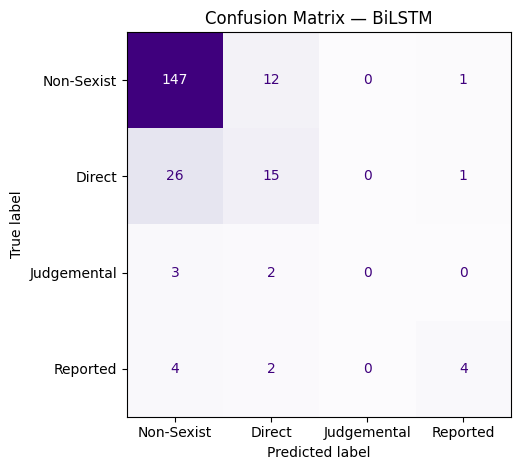

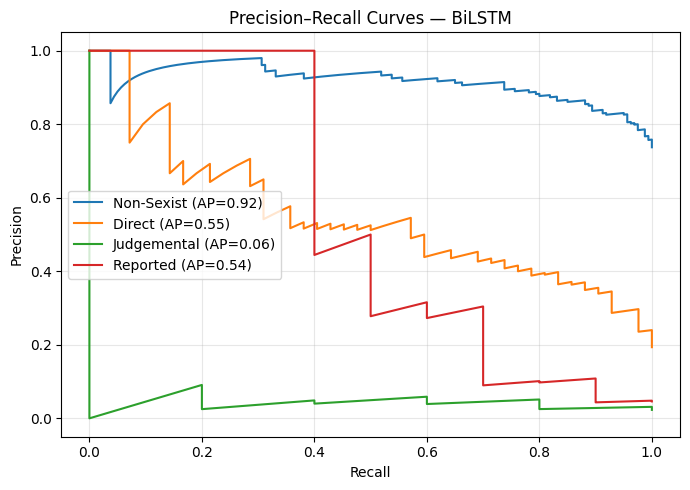

Total errors: 51 / 217

Tweet: @themaxburns @GOP Fuck that cunt. Tried to vote her out multiple times...
True: Direct | Pred: Non-Sexist
----------------------------------------
Tweet: @FernsLewds “Mmm, fuck that cunt is hungry for this dick isn’t it~ Such a shame that you can lie all you want about not ...
True: Direct | Pred: Non-Sexist
----------------------------------------
Tweet: @BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing "gende...
True: Reported | Pred: Non-Sexist
----------------------------------------
Tweet: "The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generatio...
True: Reported | Pred: Non-Sexist
----------------------------------------
Tweet: @MrsGreyBull @Miriam2626 Ah! Look! Gender roles are back, too! The don’t believe their own lies....
True: Direct | Pred: Non-Sexist
----------------------------------------


In [ ]:
# BiLSTM Error Analysis
y_true = y_test
y_pred = np.argmax(y_probs, axis=1)
y_probs = base_best_model.predict(X_test)

labels = ['Non-Sexist', 'Direct', 'Judgemental', 'Reported']

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=labels,
    cmap="Purples",
    colorbar=False
)
plt.title("Confusion Matrix — BiLSTM")
plt.tight_layout()
plt.show()

# Precision–Recall Curves
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

plt.figure(figsize=(7,5))
for i, label in enumerate(labels):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i], y_probs[:, i]
    )
    ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, label=f"{label} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — BiLSTM")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Sample Error Analysis
err_idx = np.where(y_pred != y_true)[0]
print(f"Total errors: {len(err_idx)} / {len(y_true)}\n")

for i in err_idx[:5]:
    tweet = df_test_proc.iloc[i]["tweet"]
    print(
        f"Tweet: {tweet[:120]}...\n"
        f"True: {labels[y_true[i]]} | Pred: {labels[y_pred[i]]}\n"
        + "-" * 40
    )


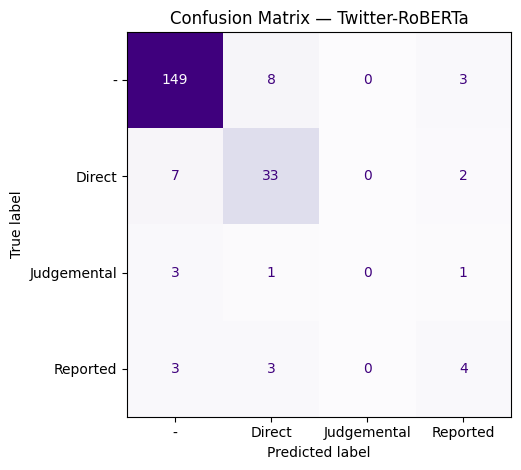

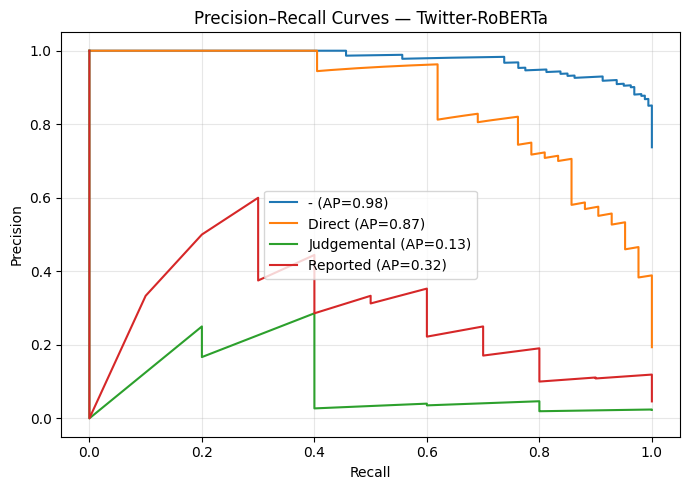

Total errors: 31 / 217

Tweet: @BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing "gende...
True: Reported | Pred: -
----------------------------------------
Tweet: "The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generatio...
True: Reported | Pred: -
----------------------------------------
Tweet: @MrsGreyBull @Miriam2626 Ah! Look! Gender roles are back, too! The don’t believe their own lies....
True: Direct | Pred: -
----------------------------------------
Tweet: @EyemotionFandom How did we reach a point where blonks are having the audacity to talk about yoongis rap do y'all see wh...
True: - | Pred: Direct
----------------------------------------
Tweet: @MatrixPirate12 Well let me ask for the guys… do you ever just grab your testicles because you can?...
True: - | Pred: Direct
----------------------------------------


In [ ]:
# Twitter-RoBERTa Error Analysis
preds = trainer.predict(hf_test)
y_true = np.array(hf_test["label"])
y_pred = np.argmax(preds.predictions, axis=1)

labels = ['-', 'Direct', 'Judgemental', 'Reported']

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=labels,
    cmap="Purples",
    colorbar=False
)
plt.title("Confusion Matrix — Twitter-RoBERTa")
plt.tight_layout()
plt.show()

# Precision–Recall Curves

y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
y_probs = torch.softmax(
    torch.tensor(preds.predictions), dim=1
).numpy()

plt.figure(figsize=(7,5))
for i, label in enumerate(labels):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i], y_probs[:, i]
    )
    ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, label=f"{label} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Twitter-RoBERTa")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Sample Error Analysis
err_idx = np.where(y_pred != y_true)[0]
print(f"Total errors: {len(err_idx)} / {len(y_true)}\n")

for i in err_idx[:5]:
    tweet = df_test_proc.iloc[i]["tweet"]
    print(
        f"Tweet: {tweet[:120]}...\n"
        f"True: {labels[y_true[i]]} | Pred: {labels[y_pred[i]]}\n"
        + "-" * 40
    )


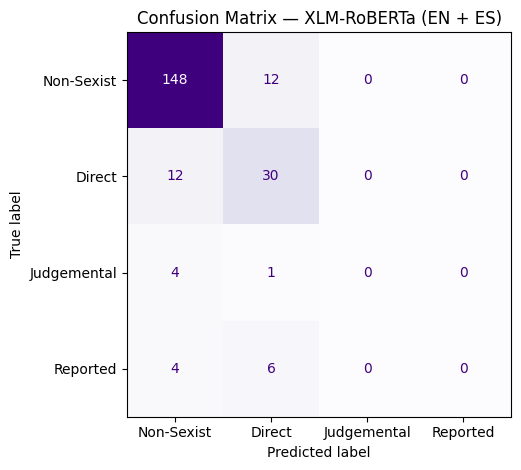

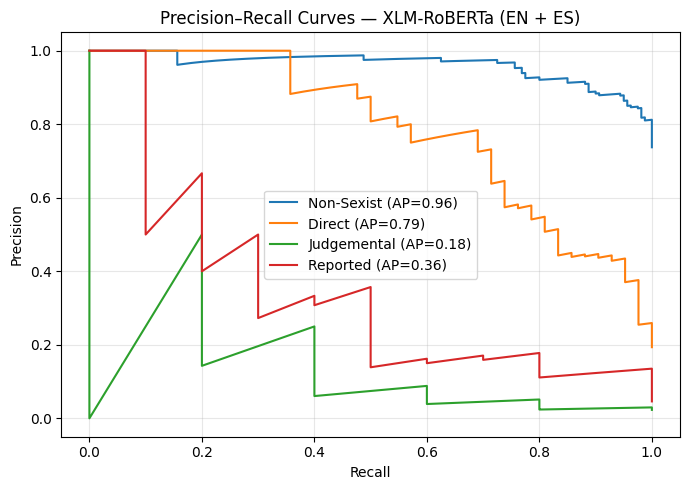

Total errors: 39 / 217

Tweet: “I mean I do, but… wouldn’t it be fun to get gangbanged together~?” https://t.co/lNRZ9z53VL...
True: Non-Sexist | Pred: Direct
----------------------------------------
Tweet: @LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring....
True: Non-Sexist | Pred: Direct
----------------------------------------
Tweet: @BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing "gende...
True: Reported | Pred: Non-Sexist
----------------------------------------
Tweet: "The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generatio...
True: Reported | Pred: Non-Sexist
----------------------------------------
Tweet: @MrsGreyBull @Miriam2626 Ah! Look! Gender roles are back, too! The don’t believe their own lies....
True: Direct | Pred: Non-Sexist
----------------------------------------


In [ ]:
# XLM-R trainer (en +es) Error Analysis
preds = trainer_xlmr.predict(hf_test)
y_true = np.array(hf_test["label"])
y_pred = np.argmax(preds.predictions, axis=1)

labels = ['Non-Sexist', 'Direct', 'Judgemental', 'Reported']

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=labels,
    cmap="Purples",
    colorbar=False
)
plt.title("Confusion Matrix — XLM-RoBERTa (EN + ES)")
plt.tight_layout()
plt.show()

# Precision–Recall Curves
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
y_probs = torch.softmax(
    torch.tensor(preds.predictions), dim=1
).numpy()

plt.figure(figsize=(7,5))
for i, label in enumerate(labels):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i], y_probs[:, i]
    )
    ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, label=f"{label} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — XLM-RoBERTa (EN + ES)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Sample Error Analysis
err_idx = np.where(y_pred != y_true)[0]
print(f"Total errors: {len(err_idx)} / {len(y_true)}\n")

for i in err_idx[:5]:
    tweet = df_test_proc.iloc[i]["tweet"]
    print(
        f"Tweet: {tweet[:120]}...\n"
        f"True: {labels[y_true[i]]} | Pred: {labels[y_pred[i]]}\n"
        + "-" * 40
    )


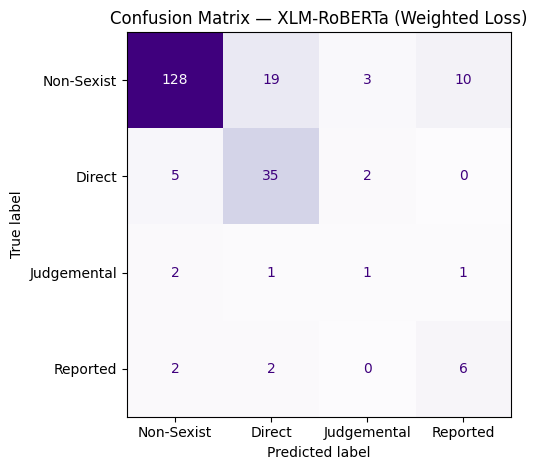

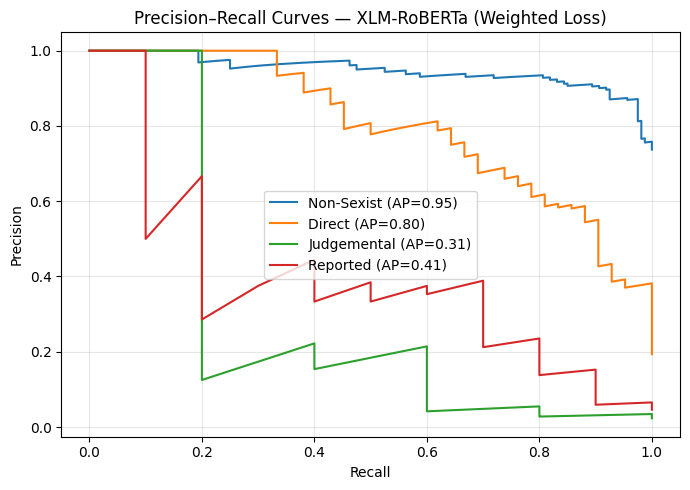

Total errors: 47 / 217

Tweet: “I mean I do, but… wouldn’t it be fun to get gangbanged together~?” https://t.co/lNRZ9z53VL...
True: Non-Sexist | Pred: Direct
----------------------------------------
Tweet: @LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring....
True: Non-Sexist | Pred: Reported
----------------------------------------
Tweet: Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably...
True: Non-Sexist | Pred: Reported
----------------------------------------
Tweet: "The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generatio...
True: Reported | Pred: Non-Sexist
----------------------------------------
Tweet: @MrsGreyBull @Miriam2626 Ah! Look! Gender roles are back, too! The don’t believe their own lies....
True: Direct | Pred: Non-Sexist
----------------------------------------


In [ ]:
# WEIGHTED XLM-R Error Analysis

preds = trainer_weighted.predict(hf_test)
y_true = np.array(hf_test["label"])
y_pred = np.argmax(preds.predictions, axis=1)

labels = ['Non-Sexist', 'Direct', 'Judgemental', 'Reported']

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=labels,
    cmap="Purples",
    colorbar=False
)
plt.title("Confusion Matrix — XLM-RoBERTa (Weighted Loss)")
plt.tight_layout()
plt.show()

# Precision–Recall Curves

y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

y_probs = torch.softmax(
    torch.tensor(preds.predictions), dim=1
).numpy()

plt.figure(figsize=(7,5))
for i, label in enumerate(labels):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i], y_probs[:, i]
    )
    ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, label=f"{label} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — XLM-RoBERTa (Weighted Loss)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Sample Error Analysis
err_idx = np.where(y_pred != y_true)[0]
print(f"Total errors: {len(err_idx)} / {len(y_true)}\n")

for i in err_idx[:5]:
    tweet = df_test_proc.iloc[i]["tweet"]
    print(
        f"Tweet: {tweet[:120]}...\n"
        f"True: {labels[y_true[i]]} | Pred: {labels[y_pred[i]]}\n"
        + "-" * 40
    )




### **7.1 Quantitative Findings: Impact of Data Imbalance**

The primary source of error identified across all models is the **severe class imbalance** present in the dataset. While the Transformer-based model achieves a relatively high overall accuracy of approximately **86%**, this metric is misleading, as it is largely dominated by the majority *Non-Sexist* class.

The confusion matrix (Figure 1) clearly highlights this disparity. The model performs very well on the *Non-Sexist* category (F1 ≈ 0.93), whereas performance on minority classes degrades substantially. In particular, the *Judgemental* class yields an F1-score of **0.00**, indicating that the model fails to correctlyly identify any instances in the test set (0/5). Similarly, the *Reported* class achieves only **40% recall** (4/10), with many samples being incorrectly classified as *Non-Sexist*. As a consequence, overall accuracy is inflated, while the **Macro F1-score (0.526)** provides a more faithful measure of balanced performance across all four categories.

Introducing a **class-weighted loss** mitigates this issue by penalizing errors on minority classes more strongly. This results in a substantial increase in recall for underrepresented categories and yields the **highest Macro F1-score** among all evaluated models, albeit at the cost of reduced overall accuracy. This trade-off reflects a reduced bias toward the majority class and improved sensitivity to minority labels.

---

### **7.2 Qualitative Findings: Common Error Patterns**

Manual inspection of misclassified samples reveals several recurring linguistic patterns:

* **Reported vs. Non-Sexist Confusion:** Tweets describing sexist events in a neutral, journalistic, or critical tone (e.g., reporting discriminatory policies or quoting sexist statements) are frequently predicted as *Non-Sexist*. The model appears to prioritize surface-level neutrality and fails to capture the underlying sexist intent expressed through reported discourse.

* **Implicit and Judgemental Sexism:** *Judgemental* tweets often rely on irony, sarcasm, or subtle framing rather than explicit slurs or insults. These pragmatic cues are difficult for current models to detect, which explains the extremely low recall observed for this class in the non-weighted setting.

* **False Positives from Aggressive Language:** Several *Non-Sexist* tweets containing emotionally charged or hostile language are misclassified as *Direct Sexism*. This suggests that the model sometimes conflates general aggression or adversarial tone with sexist intent when gendered terms appear in negative contexts, even when the underlying message is not sexist.

---

### **7.3 Model Comparison: BiLSTM vs. Transformer vs. Multilingual Training**

The Macro F1 comparison (Figure 2) highlights a clear performance gap between model families. Transformer-based models consistently outperform both BiLSTM variants (Macro F1 ≈ **0.526** vs. **0.41–0.44**).

This difference can be attributed to two key factors:

* **Subword Tokenization:** Transformer models effectively mitigate Out-of-Vocabulary (OOV) issues, which reach approximately **8.5%** in the evaluation splits. In contrast, BiLSTM models relying on static GloVe embeddings struggle with rare words, slang, and creative spellings.

* **Contextual Embeddings:** Unlike static embeddings, Transformer representations dynamically model word meaning based on surrounding context, which is crucial for detecting implicit or pragmatic forms of sexism.

Training XLM-RoBERTa on **multilingual data (English + Spanish)** yields competitive performance on English test data but does not outperform the monolingual Twitter-RoBERTa baseline. This indicates that multilingual exposure alone does not overcome class imbalance or domain-specific challenges. However, when combined with class-weighted loss, the multilingual model achieves improved recall and the **best overall Macro F1-score**, demonstrating that cross-lingual representations become effective when imbalance is explicitly addressed.

---

### **7.4 Limitations and Future Directions**

Despite the improvements obtained through class-weighted training, several limitations remain. In particular, multilingual training with XLM-RoBERTa (English + Spanish) does not lead to performance gains when used in isolation. This suggests that **cross-lingual transfer alone is insufficient** to address the challenges of fine-grained sexism classification in this dataset.

A likely explanation is that multilingual data increases linguistic diversity without directly targeting **label imbalance** or **pragmatic ambiguity**. While additional languages may enrich lexical and syntactic representations, they do not provide explicit supervision for underrepresented English categories such as *Judgemental* and *Reported* sexism. Moreover, differences in domain and discourse style across languages may introduce additional noise, limiting the benefits of multilingual training in a flat multi-class setting.

To further address the observed error patterns, several research-backed directions could be explored:

* **Targeted Data Augmentation:** Generating additional training examples specifically for minority classes through paraphrasing or back-translation can improve generalization in low-resource settings
  *(Sennrich et al., 2016)*.

* **Hierarchical Classification Architectures:** A two-stage approach—first detecting whether a tweet is sexist, followed by intent classification—may reduce confusion introduced by direct multi-class classification
  *(Silla & Freitas, 2011)*.

* **Pragmatic and Discourse-Aware Modeling:** Incorporating features related to irony, quotation, and reported speech could help distinguish between direct sexist content and neutral reporting
  *(Karoui et al., 2017)*.

* **Domain-Adaptive Pretraining:** Further pretraining on in-domain social media corpora focused on abusive or discriminatory language may improve sensitivity to implicit and contextual forms of sexism
  *(Gururangan et al., 2020)*.


# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is **not a copy-paste** of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

## Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions

**Note**: bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Suggestions for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 5 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Expected Results

Task 2 leaderboard reports around 40-50 F1-score.
However, note that they perform a hierarchical classification.

That said, results around 30-40 F1-score are **expected** given the task's complexity.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.


# The End

Feel free to reach out for questions/doubts!